In [19]:
from huggingface_hub import notebook_login
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import PeftModel, PeftConfig
from tqdm.notebook import tqdm
hf_token = 
from huggingface_hub import login
import os
import pandas as pd
from peft import PeftModel, PeftConfig
login(token=hf_token)
import numpy as np
import pandas as pd

In [ ]:
## Knowledge fusion

## Knowledge fusion

In [20]:
import pandas as pd
df = pd.read_csv('coded_transcript (2).csv')

In [21]:
filtered_df = df[["utterance", "Llama3_Code", "Falcon_Code", "Mistral_Code"]]

In [22]:
filtered_df

,utterance,Llama3_Code,Falcon_Code,Mistral_Code
0,Ik heropen het de vergadering. Aan de orde is ...,Main idea: The speaker is opening a parliament...,The main idea of the sentence is that the spea...,This sentence is about an annual debate in a c...
1,"Dank, voorzitter. Het zijn spannende tijden. D...","Main idea: ""Europe must become independent fro...",NaN,This sentence is about the challenging times w...
2,"Voorzitter, ik neem aan dat we interrupties mo...","Main idea: ""Requesting permission to interrupt...",The main idea of the sentence is that interrup...,The chairman is proposing to allow interruptio...
3,"Ja, zes in totaal.","""Zes in totaal"" (Six in total) </assistant>","The main idea of the sentence is ""Yes, everyth...","Yes, there are six in total.</s>"
4,"Mevrouw Rooderkerk noemt de PVV en de BBB ""een...","""PVV and BBB threaten safety"" </assistant><|eo...",The main idea of the sentence is that the PVV ...,"This sentence means ""Mrs. Rooderkerk labels PV"
...,...,...,...,...
505,"Nogmaals, die consensus is er niet. Ik heb ver...","The main idea of this sentence is: ""The minist...",<human>: <human>: <human>: <human,The speaker values science and its independenc...
506,"Afrondend, mevrouw De Vos.","The main idea is: ""Goodbye, Mrs. De Vos.""",The sentence describes a meeting between two p...,The sentence appears to be in Dutch and transl...
507,"Ja, tot slot. We gaan hier duidelijk niet uit ...","The main idea of this sentence is: ""The minist...",<noinput>,The speaker defends her position based on scie...
508,De minister gaf op een aantal andere vlakken a...,Main idea: The minister is open to exploring n...,The Minister of Energy is now speaking. Minis...,The minister focused on explaining the acceler...


## Dutch stuff


In [ ]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
import torch

df = filtered_df

# Load Mixtral model locally
model_name = "mistralai/Mixtral-8x7B-Instruct-v0.1"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map="auto",
)

# Create pipeline
pipe = pipeline("text-generation", model=model, tokenizer=tokenizer)

# Define description
textdescription = 'Dutch parliamentary debate'

# List for storing codes
generated_codes = []

# Loop through rows
for index, row in df.iterrows():
    prompt = f"""
    [INST] You are a coding assistant skilled in thematic analysis.

    You will be given a paragraph from the text, which is: {textdescription}.

    Definition of the code: A word or short phrase that symbolically assigns a summative, salient, essence-capturing, and/or evocative attribute for a portion of language-based or visual data.

    Here is the excerpt to code:
    {row['utterance']}

    Here are three coding suggestions from previous models:
    1. {row['Llama3_Code']}
    2. {row['Falcon_Code']}
    3. {row['Mistral_Code']}

    Please suggest a code taking into account all these answers.
    Output should be the code with no longer than 5 words. [/INST]
    """.strip()

    # prompt_without = f"""
    # You will be given a paragraph.

    # Definition of the code: A word or short phrase that symbolically assigns a summative, salient, essence-capturing, and/or evocative attribute for a portion of language-based or visual data.

    # Here is the excerpt to code:
    # {row['utterance']}

    # Output should be the code with no longer than 5 words.
    # """

    try:
        output = pipe(
            prompt,
            max_new_tokens=20,
            do_sample=True,
            temperature=0.7,
            top_p=0.9,
            num_return_sequences=1,
        )[0]["generated_text"]

        response = output.split("[/INST]")[-1].strip()
        generated_codes.append(response)
        print(f"Generated code for row {index}: {response}")

    except Exception as e:
        print(f"Error generating code for row {index}: {e}")
        generated_codes.append(None)

# Store in DataFrame
df['Generated_Code'] = generated_codes
df.to_csv('updated_dataframe_with_mixtral8x7b_local.csv', index=False)
print("Saved to 'updated_dataframe_with_mixtral8x7b_local.csv'.")


Loading checkpoint shards: 100%|██████████| 19/19 [22:43<00:00, 71.74s/it] 
Some parameters are on the meta device because they were offloaded to the cpu.
Device set to use cuda:0
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 0: "Annual climate and energy debate"


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 1: "Europe's independence urgency"


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 2: "Requesting permission for initial interruptions"


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 3: Six items in total.

Confidence: 95%.


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 4: "Rooderkerk views PVV, BBB as safety threats"


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 5: "Perplexity over Dutch gas independence"


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 6: "Asking questions during my speech"


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 7: Mr. Vermeer requested response time.


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 8: Continue argument presentation.


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 9: "Urgent call for robust climate policy"


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 10: "Mrs. Beckerman speaks for Socialist Party"


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 11: "SP's concern: Unfair, uncertain energy policy"


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 12: "Thanking Mr. Erkens' Introduced Speech"


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 13: "Realistic energy policies urgency"


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 14: "Postma: First Speaker"


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 15: "Erkens' plan for fossil winning"


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 16: "Urgent action needed for North Sea gas exploration"


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 17: Importance of parliamentary clarity


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 18: "Minister urged for swift Ternaard permits"

Explanation: This code


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 19: Consideration for hybrid heat pumps norming withdrawn


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 20: "Hybrid heat pumps' benefits"


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 21: Coalition's stance on national heating plants impact.


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 22: "Proposed hardship clause for CO2 tax"


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 23: "Erkens' proposal: Geopolitical threats and climate savings intertwined"


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 24: "Balanced energy production view"


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 25: "Erkens' Focus on National Climate Goals"


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 26: "Urgent action for energy independence"


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 27: "Dutch government's 55% CO2 reduction goal"


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 28: Achieving Cooperation, Retaining Industry in Netherlands


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 29: "Erkens' Contradictory 'Clean Fossil' Comment"


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 30: "Inconsistency in Greenchoice's solar energy pricing"


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 31: Loss of trust in solar panel policies


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 32: Solar panels should retain profits.


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 33: VVD's stance on solar panel costs in rent


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 34: "Considering costs in solar panel implementation"


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 35: "Erkens' concept of 'clean' fossil energy"


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 36: "Urging pragmatic energy transition"


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 37: "Erkens' involvement in gas production"


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 38: Affirmative Agreement


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 39: "Criticism of unrealistic anti-climate plan"


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 40: "Netherlands' continued gas dependence beyond 2030"


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 41: VVD's commitment to 2030 climate goals evaluation


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 42: "Concrete actions, no symbolism"


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 43: "SDE budget reduction impact"


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 44: Continue SDE++ funding necessary

This code captures the main idea of the excer


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 45: "Querying specific climate actions"


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 46: "Government action for energy grid capacity"


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 47: "Urgent actions lacking by Erkens"


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 48: Implement existing green plans, address barriers


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 49: "VVD resistance to clear goals"


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 50: "High energy costs driving businesses away"


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 51: VVD: Clarify stance, seize sustainability chances

This code captures the main


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 52: "Inadequate climate policy progress"


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 53: Disagreement over climate goals tackling

This code captures the essence of the excer


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 54: Intrinsic motivation for climate goals' achievement


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 55: "Mevrouw Koekkoek, fourth reference"


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 56: "Embracing climate action initiative"


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 57: "Prioritizing clean industry grid connections, considering Dutch-Chinese collaboration and potential industry losses


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 58: "Mrs. Teunissen repeated mention"


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 59: Criticizing VVD for insufficient climate action


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 60: "Asking for question" or "Question inquiry"


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 61: "VVD's inquiries on climate packages"


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 62: "Speaker's questions on promoting electric driving"


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 63: "VVD's stance on challenging climate targets"


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 64: "Governmental measures for energy independence and climate goals"

Explanation: This


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 65: "Questioning feasibility of goals"


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 66: "Opposes proposed climate measures"


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 67: VVD's climate approach deemed more realistic.


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 68: "Prioritize Political Choices for Goals"

Explanation: This code capt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 69: "Erkens' Continuing Speech"


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 70: "Expedite energy projects' permits"


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 71: "Mrs. Kröger speaking for GroenLinks"


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 72: "Government: Take urgent action for security & sustainability"


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 73: Expressing gratitude, acknowledges Mrs. Koekkoek's turn


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 74: "Cabinet lagging in climate action"


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 75: "Mrs. Postma's turn, NSC faction"


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 76: "Urgent wind energy expansion"


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 77: Dutch: A moment.

I combined the definition of the word "Een ogenbl


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 78: "Complete my sentence"


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 79: Affirmative response


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 80: "Minister's Tender Assurance"


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 81: "High energy prices explanation"


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 82: "Company Bidding Uncertainties"


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 83: "Decreasing demand, inflated investment proposal"


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 84: "Dutch ownership of wind farm cables"


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 85: "No need for cables"


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 86: "Investing in self-sufficient green energy"


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 87: "Continue Speech, Mrs. Postma"


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 88: "Advocating Practical, Community-Focused Energy Policies"


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 89: "Gratitude towards Heer Bontenbal"


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 90: Speaker's focus on hybrid heat pump and sector agreements


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 91: "Speaker's admiration for Bontenbal's heat pump use"


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 92: "Support for hybrid heating systems' sustainability"


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 93: "Bontenbal's endorsement of hybrid heat pump"


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 94: "Government energy sector progress"


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 95: Aspiration for smaller agriculture


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 96: "Urgent action needed for nitrogen reduction"


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 97: "Ministers accountable for goals"


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 98: "Deferring Teunissen's announcement"


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 99: "Endorsement of Climate Package & North Sea Pact"


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 100: Ensure matching supply and demand

This code captures the main idea of the excerpt,


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 101: "Gratitude for Contribution"


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 102: "Governmental funding for offshore wind energy costs"


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 103: Implement diverse measures for internet congestion.


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 104: "Teunissen Speaks for Animal Party"

This code captures the main idea of


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 105: "Urgent Call for Decisive Climate Action"


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 106: "Introducing next BBB speaker"


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 107: "Urgent action needed for effective climate policy"


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 108: "Gratitude expressed to Heer Bontenbal"


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 109: "Execution hindered, partial car-lamp comparison"


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 110: "Expression of gratitude"


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 111: "Agriculture's role in meeting climate target"

This code captures the


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 112: "Agriculture's significant greenhouse gas reductions"


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 113: "Speaker Bontenbal's interruption"


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 114: "Taking opportunity to keep associates with speaker"


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 115: "No interruptions during speaking time"


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 116: "Lower CO2 production/kg"

This code combines the main ideas of the previous


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 117: "Bontenbal's turn to speak"


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 118: "Speaker's Last Interruption"


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 119: Affirmation in Dutch: "That's correct"


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 120: Expressing disappointment.


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 121: "Integrated goals for efficiency"


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 122: "Urgent action needed on stikstof"

Explanation: This code


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 123: Dutch IenW State Secretary


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 124: "Self-reliant solution seeking"


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 125: Response needed in Dutch context.


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 126: "Affirmative statement in Dutch"


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 127: "Correlation: Ammonia & Greenhouse Gas Emissions"


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated code for row 128: "Disappointment over unimplemented motion"


In [39]:
from groq import Groq
import os
import pandas as pd

# Load your dataframe
df = filtered_df.iloc[388:]
api_key = 

# Initialize Groq client
client = Groq(
    api_key=api_key,  # Pass the API key directly
)


# Define the text description
textdescription = 'Dutch parliamentary debate'

# Create a list to store generated codes
generated_codes = []

# Iterate over rows in the dataframe

# Iterate over the dataframe rows
for index, row in df.iterrows():
    # Prepare the input prompt
    prompt = f"""
    You will be given a paragraph from the text, which is: {textdescription}.

    Definition of the code: A word or short phrase that symbolically assigns a summative, salient, essence-capturing, and/or evocative attribute for a portion of language-based or visual data.

    Here is the excerpt to code:
    {row['utterance']}

    Here are three coding suggestions from previous models:
    1. {row['Llama3_Code']}
    2. {row['Falcon_Code']}
    3. {row['Mistral_Code']}

    Please suggest a code taking into account all these answers.
    Output should be the code with no longer than 5 words.
    """

    prompt_without = f"""
    You will be given a paragraph.

    Definition of the code: A word or short phrase that symbolically assigns a summative, salient, essence-capturing, and/or evocative attribute for a portion of language-based or visual data.

    Here is the excerpt to code:
    {row['utterance']}

    Output should be the code with no longer than 5 words.
    """

    try:
        # Call the Groq API to generate a response
        chat_completion = client.chat.completions.create(
            messages=[
                {
                    "role": "system",
                    "content": "You are a coding assistant skilled in thematic analysis."
                },
                {
                    "role": "user",
                    "content": prompt
                }
            ],
            model="llama-3.3-70b-versatile",
        )

        # Extract the generated content
        generated_code = chat_completion.choices[0].message.content
        generated_codes.append(generated_code)

        print(f"Generated code for row {index}: {generated_code}")

    except Exception as e:
        print(f"Error generating code for row {index}: {e}")
        generated_codes.append(None)

# Add the generated codes to the dataframe
df['Generated_Code'] = generated_codes

# Save the updated dataframe to a new CSV file
df.to_csv('updated_dataframe_with_llama3_codes_388a.csv', index=False)

print("Generated codes saved to 'updated_dataframe_with_groq_codes.csv'.")

Generated code for row 388: Final warning to Rooderkerk.
Generated code for row 389: Implementing government policy goals
Generated code for row 390: Minister defends climate policy
Generated code for row 391: Minister begins her speech.
Generated code for row 392: Acknowledging interruptions.
Generated code for row 393: Climate policy commitment
Generated code for row 394: Sand availability concern.
Generated code for row 395: Minister answers his question.
Generated code for row 396: "Speaker expects more questions"
Generated code for row 397: Electric car charging query.
Generated code for row 398: "Smart Charging Plan Discussion"
Generated code for row 399: Smart Charging Regulation Discussion
Generated code for row 400: Final interruption, Mrs Postma. 

Alternatively, a shorter code: Last Interruption
Generated code for row 401: Government targets for loading.
Generated code for row 402: Electric vehicle transition plans.
Generated code for row 403: Last Interruption Warning
Gener

/tmp/ipykernel_94/4141366332.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Generated_Code'] = generated_codes


Here we compute BERTscore, and then compute BERTscore after RAG

## RAG

In [40]:
df_cleaned = pd.read_csv('updated_dataframe_with_llama3_codes.csv')

In [41]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# Load the cleaned DataFrame
df = df_cleaned.copy()

# Reset index to ensure it is sequential
df = df.reset_index(drop=True)

# Initialize Sentence-BERT model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Generate sentence embeddings for the paragraphs
embeddings = model.encode(df['utterance'].tolist(), convert_to_tensor=False)

# Compute the cosine similarity matrix
cosine_sim_matrix = cosine_similarity(embeddings)

# Define a similarity threshold (adjust based on the desired strictness)
similarity_threshold = 0.8

# Track changes in Final_Code
updates = []

# Function to assign a code based on similarity
def assign_similar_codes(row_idx, dataframe):
    similarities = cosine_sim_matrix[row_idx, :row_idx]  # Compare only with previous rows
    similar_indices = [i for i, score in enumerate(similarities) if score >= similarity_threshold]

    # If similar indices exist, assign the first matching Final_Code
    for idx in similar_indices:
        new_code = dataframe.at[idx, 'Generated_Code']
        if new_code != dataframe.at[row_idx, 'Generated_Code']:
            updates.append({
                "Paragraph": dataframe.at[row_idx, 'utterance'],
                "Original_Final_Code": dataframe.at[row_idx, 'Generated_Code'],
                "Updated_Final_Code": new_code,
                "Similar_Paragraph": dataframe.at[idx, 'utterance']
            })
            return new_code

    # Otherwise, keep the original code
    return dataframe.at[row_idx, 'Generated_Code']

# Apply the function to assign similar codes
df['Final_Code'] = [
    assign_similar_codes(idx, df) for idx in range(len(df))
]

# Convert updates to a DataFrame for review
updates_df = pd.DataFrame(updates)

# Save updates and final DataFrame
updates_df.to_csv('code_updates_1.csv', index=False)
df.to_csv('debatesrag_llama3.csv', index=False)

# Print before and after updates for review
print("=== Updates Made ===")
print(updates_df)
print("\n=== Updated DataFrame Preview ===")
print(df.head())


=== Updates Made ===
                                             Paragraph  \
0    Hartelijk dank voor uw inbreng. We gaan nu lui...   
1    We moeten het dan wel eerst eens zijn over die...   
2    Ik heb vier minuten voor mijn inbreng en ik he...   
3    Dank voor uw inbreng. We gaan nu luisteren naa...   
4    Hartelijk dank voor uw inbreng. We gaan nu lui...   
..                                                 ...   
118  Daarmee is de motie op stuk nr. 1489 ontraden....   
119  Ik heb toch een vraag over de vorige motie, om...   
120  Nee, voorzitter. Er staat alleen "concrete maa...   
121  Dan de motie op stuk nr. 1484.  Minister Herma...   
122  De minister gaf op een aantal andere vlakken a...   

                     Original_Final_Code  \
0          Introduction to next speaker.   
1                 "Need for Clear Goals"   
2             "Speaker's Remaining Time"   
3    Introduction to GroenLinks speaker.   
4      Expression of gratitude received.   
..                

## Analysis

In [42]:
import pandas as pd
mixtral_df = pd.read_csv('debatesrag_mixtral - debatesrag_mixtral.csv')
llama3_df = pd.read_csv('debatesrag_llama3 - debatesrag_llama3.csv')

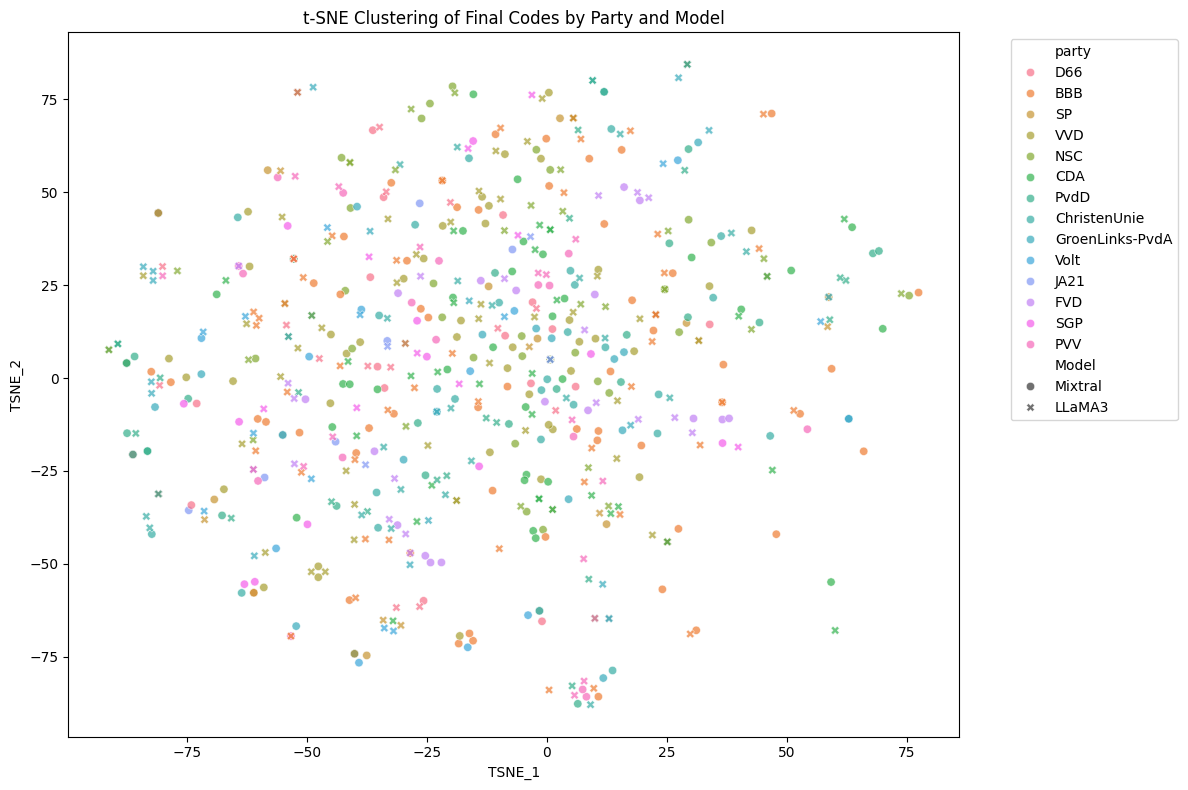

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

# Combine both datasets with source label
mixtral_df["Model"] = "Mixtral"
llama3_df["Model"] = "LLaMA3"
combined_df = pd.concat([mixtral_df, llama3_df], ignore_index=True)

# Filter out rows with no code
filtered = combined_df[combined_df["Final_Code"].notnull()].copy()

# Vectorize Final_Code using TF-IDF
vectorizer = TfidfVectorizer(max_features=300)
X = vectorizer.fit_transform(filtered["Final_Code"])

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, init="pca", learning_rate="auto")
tsne_results = tsne.fit_transform(X.toarray())

# Add t-SNE results to dataframe
filtered["TSNE_1"] = tsne_results[:, 0]
filtered["TSNE_2"] = tsne_results[:, 1]

# Plot t-SNE, colored by party
plt.figure(figsize=(12, 8))
sns.scatterplot(data=filtered, x="TSNE_1", y="TSNE_2", hue="party", style="Model", alpha=0.7)
plt.title("t-SNE Clustering of Final Codes by Party and Model")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [47]:

keywords = ["climate", "migration", "economy"]

filtered_keywords_df = combined_df[
    combined_df["Final_Code"].str.contains("|".join(keywords), case=False, na=False)
].copy()

results = []
for keyword in keywords:
    keyword_rows = filtered_keywords_df[filtered_keywords_df["Final_Code"].str.contains(keyword, case=False, na=False)]
    keyword_counts = keyword_rows["party"].value_counts()
    for party, count in keyword_counts.items():
        results.append({
            "Keyword": keyword,
            "Party": party,
            "Frequency": count
        })

keyword_stats = pd.DataFrame(results).sort_values(["Keyword", "Frequency"], ascending=[True, False])

keyword_stats

,Keyword,Party,Frequency
0,climate,PvdD,19
1,climate,CDA,16
2,climate,BBB,15
3,climate,ChristenUnie,15
4,climate,D66,13
5,climate,FVD,13
6,climate,GroenLinks-PvdA,11
7,climate,VVD,11
8,climate,Volt,9
9,climate,JA21,8


In [48]:

def get_top_final_codes(df, model_name, top_n=20):
    code_counts = df["Final_Code"].value_counts().head(top_n).reset_index()
    code_counts.columns = ["Final_Code", "Frequency"]
    code_counts["Model"] = model_name
    return code_counts

top_mixtral_codes = get_top_final_codes(mixtral_df, "Mixtral")
top_llama3_codes = get_top_final_codes(llama3_df, "LLaMA3")

top_codes_df = pd.concat([top_mixtral_codes, top_llama3_codes], ignore_index=True)
top_codes_df



,Final_Code,Frequency,Model
0,Motion proposed by Rooderkerk & Koekko.,11,Mixtral
1,"""Speaker's last interruption.""",9,Mixtral
2,Criticizing VVD for insufficient climate action,8,Mixtral
3,"""Mrs. Beckerman speaks for Socialist Party""",8,Mixtral
4,"""Annual climate and energy debate""",7,Mixtral
5,"""Advocating Practical, Community-Focused Energ...",7,Mixtral
6,Solar panels should retain profits.,6,Mixtral
7,Loss of trust in solar panel policies,5,Mixtral
8,"""Motion proposal by Beckerman, Teunissen""",5,Mixtral
9,"""Caution against hastened Russian energy indep...",5,Mixtral


## Type of codes

In [67]:
# Define procedural/structural keywords
procedural_keywords = [
    "interruption", "interrupt", "speaker", "speaks", "chair", "motion", 
    "vote", "voting", "session", "thank", "debate", "announcement", "proposed", "submitted",
    "introduction", "affirmative", "mrs", "mr.", "mr ", "mrs ", "speaker", "speaking", "request",
    "expression", "gratitude", "minister"
]

def classify_code(code):
    code_lower = str(code).lower()
    if any(keyword in code_lower for keyword in procedural_keywords):
        return "Procedural"
    return "Topical"

mixtral_df["Code_Type"] = mixtral_df["Final_Code"].apply(classify_code)
llama3_df["Code_Type"] = llama3_df["Final_Code"].apply(classify_code)

mixtral_counts = mixtral_df["Code_Type"].value_counts().rename_axis("Code_Type").reset_index(name="Count")
mixtral_counts["Model"] = "Mixtral"

llama3_counts = llama3_df["Code_Type"].value_counts().rename_axis("Code_Type").reset_index(name="Count")
llama3_counts["Model"] = "LLaMA3"

code_type_counts = pd.concat([mixtral_counts, llama3_counts], ignore_index=True)

code_type_counts


,Code_Type,Count,Model
0,Topical,316,Mixtral
1,Procedural,194,Mixtral
2,Topical,332,LLaMA3
3,Procedural,178,LLaMA3


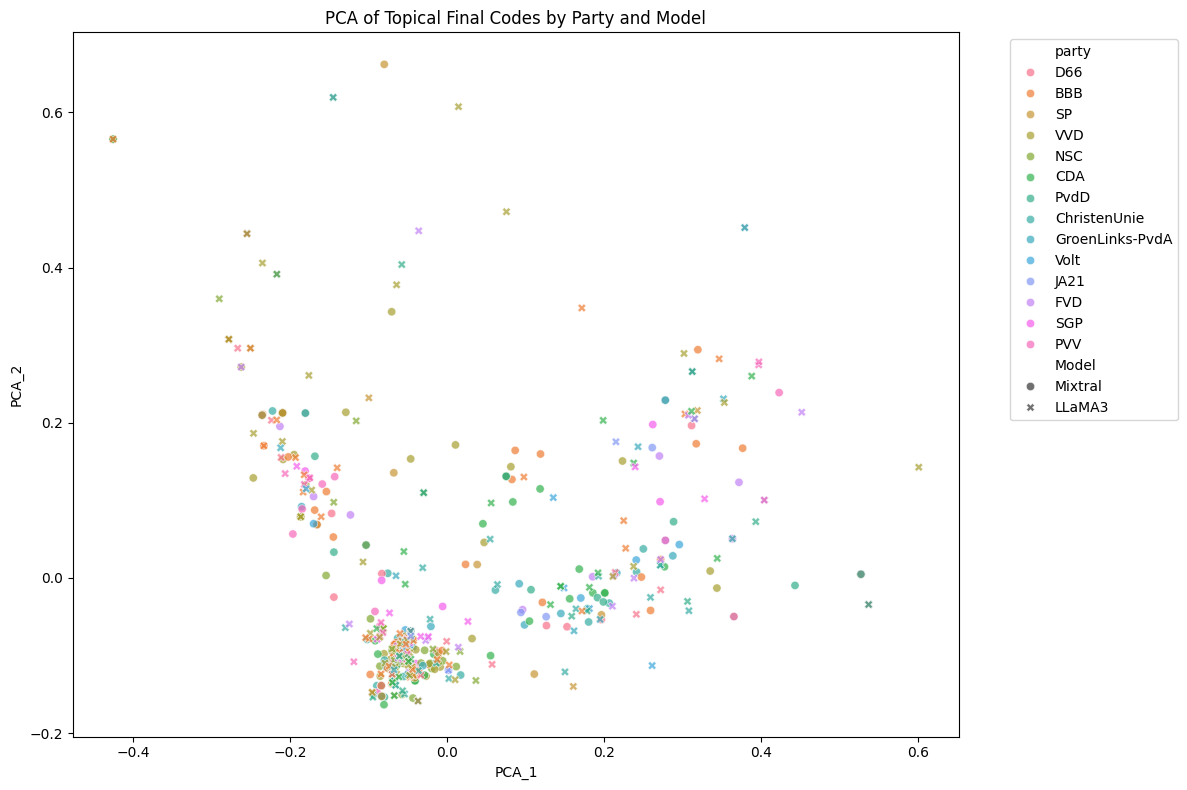

In [68]:
from sklearn.decomposition import PCA

topical_df = pd.concat([
    mixtral_df[mixtral_df["Code_Type"] == "Topical"].assign(Model="Mixtral"),
    llama3_df[llama3_df["Code_Type"] == "Topical"].assign(Model="LLaMA3")
], ignore_index=True)

vectorizer = TfidfVectorizer(max_features=300)
X_topical = vectorizer.fit_transform(topical_df["Final_Code"].astype(str))
pca = PCA(n_components=2)
pca_results = pca.fit_transform(X_topical.toarray())

topical_df["PCA_1"] = pca_results[:, 0]
topical_df["PCA_2"] = pca_results[:, 1]

plt.figure(figsize=(12, 8))
sns.scatterplot(data=topical_df, x="PCA_1", y="PCA_2", hue="party", style="Model", alpha=0.7)
plt.title("PCA of Topical Final Codes by Party and Model")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


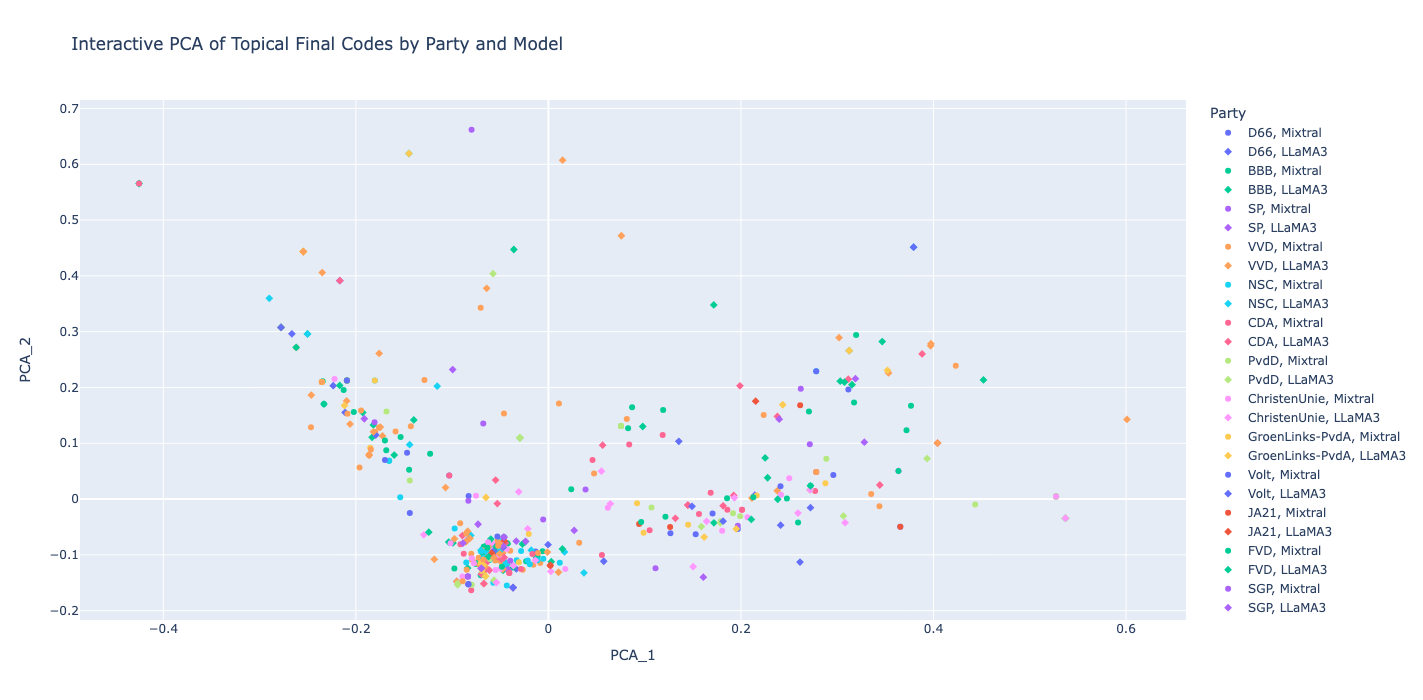

In [69]:
import plotly.express as px

# Use stricter topical-only cleaned DataFrame from previous steps
fig = px.scatter(
    topical_df,
    x="PCA_1",
    y="PCA_2",
    color="party",
    symbol="Model",
    hover_data=["Final_Code", "party", "Model"],
    title="Interactive PCA of Topical Final Codes by Party and Model"
)

fig.update_layout(
    legend_title_text="Party",
    height=700,
    width=1000
)

fig.show()


Batches: 100%|██████████| 21/21 [00:00<00:00, 135.65it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



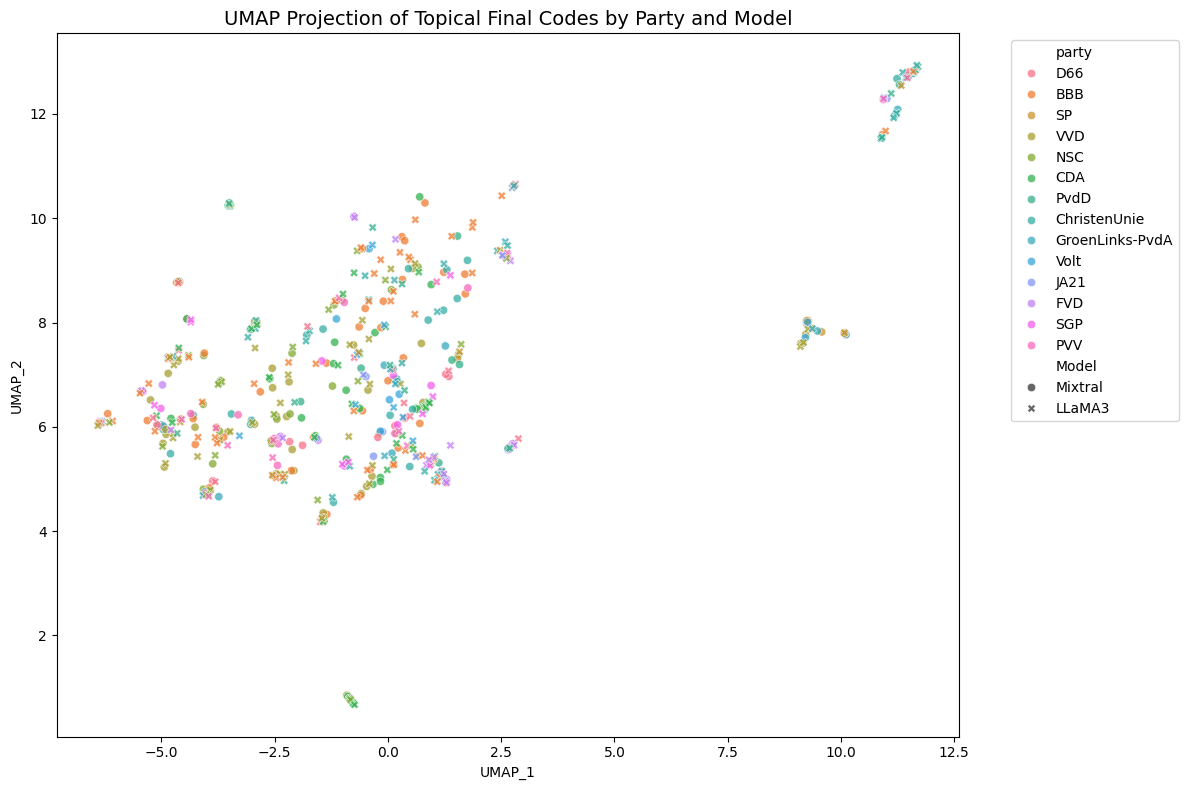

In [70]:
from sentence_transformers import SentenceTransformer
import umap
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

combined_df = pd.concat([mixtral_df, llama3_df], ignore_index=True)
combined_df = combined_df[combined_df["Final_Code"].notnull()].copy()

procedural_keywords = [
    "interruption", "interrupt", "speaker", "speaks", "chair", "motion", 
    "vote", "voting", "session", "thank", "debate", "announcement", "proposed", "submitted",
    "introduction", "affirmative", "mrs", "mr.", "mr ", "mrs ", "speaker", "speaking", "request",
    "expression", "gratitude", "minister"
]
def classify_code(code):
    code_lower = str(code).lower()
    if any(keyword in code_lower for keyword in procedural_keywords):
        return "Procedural"
    return "Topical"
combined_df["Code_Type"] = combined_df["Final_Code"].apply(classify_code)

topical_df = combined_df[combined_df["Code_Type"] == "Topical"].copy()

model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = model.encode(topical_df["Final_Code"].tolist(), show_progress_bar=True)

reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine', random_state=42)
embedding_2d = reducer.fit_transform(embeddings)

topical_df["UMAP_1"] = embedding_2d[:, 0]
topical_df["UMAP_2"] = embedding_2d[:, 1]

plt.figure(figsize=(12, 8))
sns.scatterplot(data=topical_df, x="UMAP_1", y="UMAP_2", hue="party", style="Model", alpha=0.75)
plt.title("UMAP Projection of Topical Final Codes by Party and Model", fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


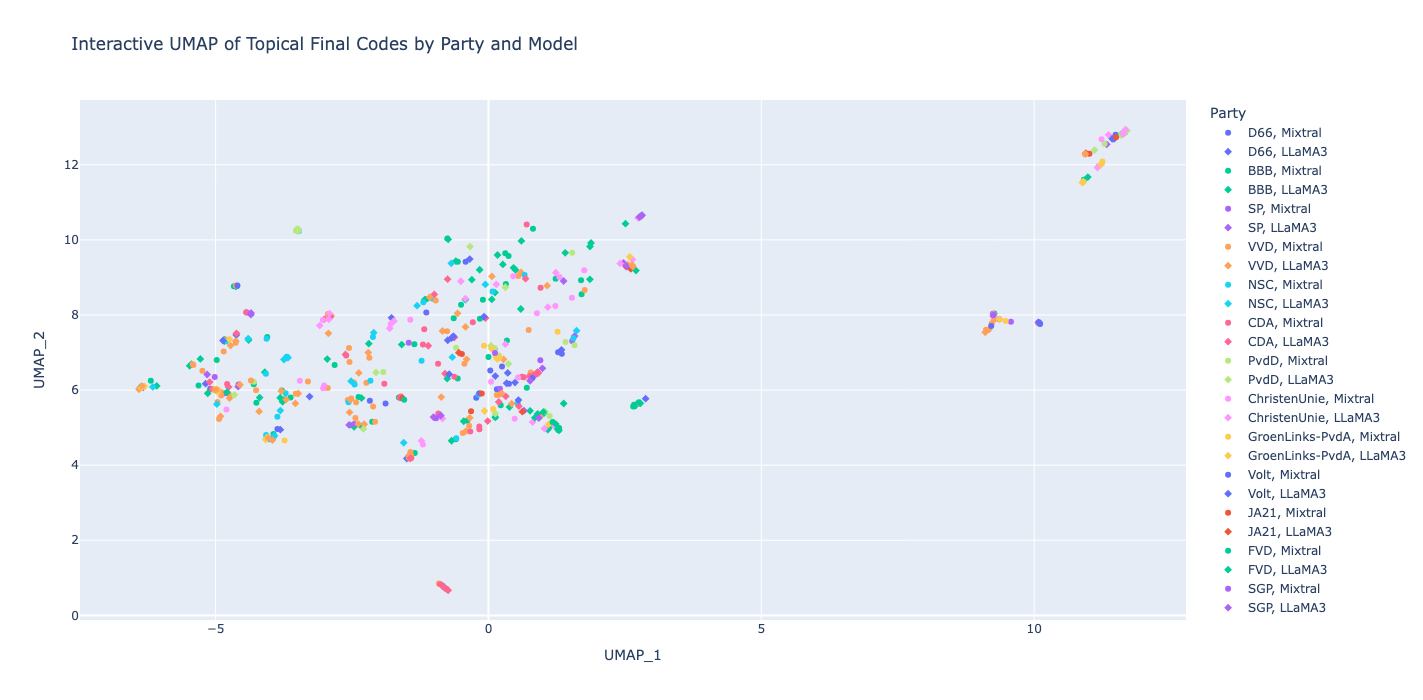

In [71]:
import plotly.express as px

# Use stricter topical-only cleaned DataFrame from previous steps
fig = px.scatter(
    topical_df,
    x="UMAP_1",
    y="UMAP_2",
    color="party",
    symbol="Model",
    hover_data=["Final_Code", "party", "Model"],
    title="Interactive UMAP of Topical Final Codes by Party and Model"
)

fig.update_layout(
    legend_title_text="Party",
    height=700,
    width=1000
)

fig.show()
